<a href="https://colab.research.google.com/github/sh1var3ddy/CNN/blob/main/efficientNet_car_dense128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import itertools
import numpy as np
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
folder_path = "/content/drive/MyDrive/classification_data_ls"

In [4]:
pic_size = 256
epochs = 20
batch_size =8
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders


splitfolders.ratio(folder_path, output='/content/', seed=42, ratio=(0.8,0.2))

Copying files: 5002 files [01:52, 44.31 files/s] 


In [5]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20, 
    width_shift_range=.2,
    height_shift_range=.2, 
    zoom_range=.2,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_set = datagen.flow_from_directory('/content/train',
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

val_set = datagen.flow_from_directory('/content/val',
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 3202 images belonging to 5 classes.
Found 198 images belonging to 5 classes.


In [6]:
print(train_set.class_indices)

{'Hatchback': 0, 'MPV': 1, 'Minivan': 2, 'SUV': 3, 'Sedan': 4}


In [30]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=(pic_size, pic_size, 3), pooling='max') 
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = tf.keras.layers.Dense(128, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer=tf.keras.regularizers.l1(0.006),
                bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
x = tf.keras.layers.Dropout(rate=.45, seed=123)(x)        
output = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [24]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                              monitor='val_loss',
                             verbose=1, 
                             save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model.summary()

In [32]:
model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [33]:
history = model.fit(train_set, 
                    validation_data = val_set,
                    epochs = 100,
                    batch_size = batch_size,
                    verbose=1,callbacks=[callback])

Epoch 1/100
401/401 [==============================] - 125s 213ms/step - loss: 5.4665 - accuracy: 0.3360 - val_loss: 4.4536 - val_accuracy: 0.4798
Epoch 2/100
401/401 [==============================] - 81s 202ms/step - loss: 4.2299 - accuracy: 0.4460 - val_loss: 3.6002 - val_accuracy: 0.5505
Epoch 3/100
401/401 [==============================] - 83s 207ms/step - loss: 3.3445 - accuracy: 0.5278 - val_loss: 3.0719 - val_accuracy: 0.5556
Epoch 4/100
401/401 [==============================] - 81s 203ms/step - loss: 2.6978 - accuracy: 0.5928 - val_loss: 2.3740 - val_accuracy: 0.6566
Epoch 5/100
401/401 [==============================] - 83s 207ms/step - loss: 2.2141 - accuracy: 0.6337 - val_loss: 2.0153 - val_accuracy: 0.7020
Epoch 6/100
401/401 [==============================] - 82s 204ms/step - loss: 1.8468 - accuracy: 0.6758 - val_loss: 1.7898 - val_accuracy: 0.6364
Epoch 7/100
401/401 [==============================] - 83s 206ms/step - loss: 1.5907 - accuracy: 0.7058 - val_loss: 1.5712 

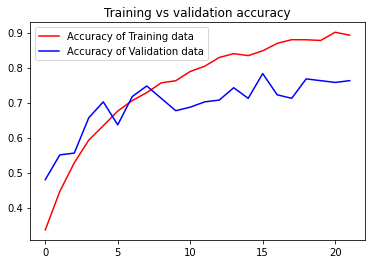

<Figure size 432x288 with 0 Axes>

In [34]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

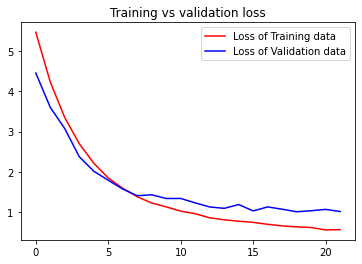

<Figure size 432x288 with 0 Axes>

In [36]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [35]:
results = model.evaluate(val_set)
preds   = model.predict(val_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

25/25 [==============================] - 8s 228ms/step
The current model achieved a categorical accuracy of 79.29%!


In [37]:
predictions = model.predict(val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

25/25 [==============================] - 4s 144ms/step


In [38]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [41]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [42]:
train_dict = dict()
walk_data(train_dict, folder_path)

In [43]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [44]:
train_dict = fix_keys(train_dict)
print(train_dict)

{'SUV': 1016, 'Sedan': 1019, 'Minivan': 977, 'Hatchback': 1010, 'MPV': 980}


In [45]:
label_train_dict = {'Car Types':train_dict.keys(), 'Count':train_dict.values}

<Figure size 432x288 with 0 Axes>

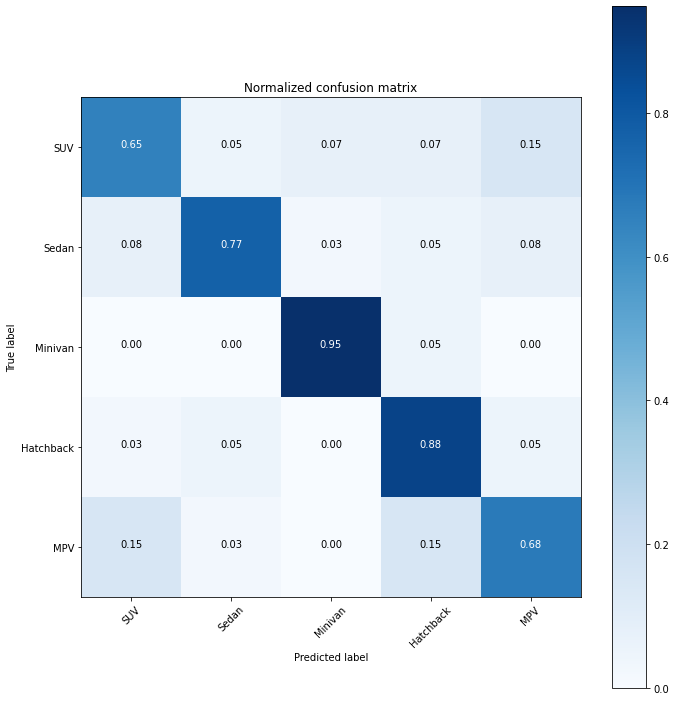

In [46]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=train_dict.keys(), title='Normalized confusion matrix')
plt.show()

In [40]:
model.save_weights('cartype_model_weights2.h5')

In [47]:
test_set = datagen.flow_from_directory('/content/drive/MyDrive/classification_dataset/test',
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 168 images belonging to 5 classes.


In [48]:
preds   = model.predict(test_set)


21/21 [==============================] - 72s 4s/step


In [50]:
results = model.evaluate(test_set)

21/21 [==============================] - 6s 280ms/step - loss: 0.9500 - accuracy: 0.7917


In [51]:
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

The current model achieved a categorical accuracy of 79.17%!
